In [571]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
sns.set_style('darkgrid')
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler, QuantileTransformer

data = pd.read_csv('datasets/train.csv')
df = data.copy()

## 1. Obtención y análisis de los datos

In [572]:
df.drop(['Name', 'PassengerId', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)

In [573]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


In [574]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [575]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
dtypes: float64(2), int64(4), object(1)
memory usage: 48.9+ KB


##### Balance del objetivo de la predicción

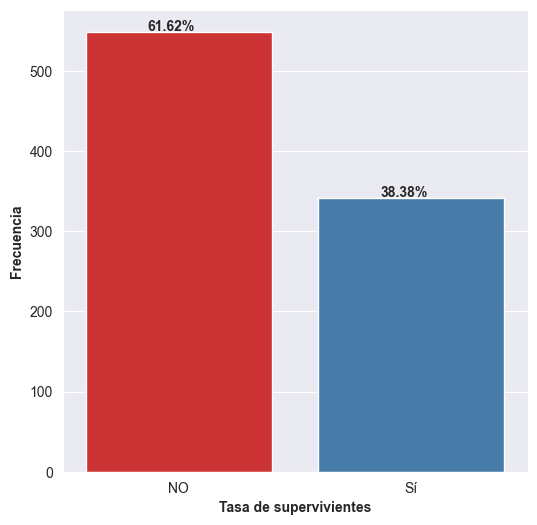

In [576]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.countplot(data=df, x='Survived', palette='Set1', hue='Survived', legend=False)
plt.xlabel('Tasa de supervivientes', weight='bold')
plt.xticks(np.arange(2), ['NO', 'Sí'])

for p in ax.patches:
    ax.annotate(f'{round(p.get_height() / len(df) * 100, 2)}%', xy=(p.get_x() + p.get_width() / 3, p.get_height() * 1.002), weight='bold')

plt.ylabel('Frecuencia', weight='bold')
plt.show()

##### Distribución de las variables

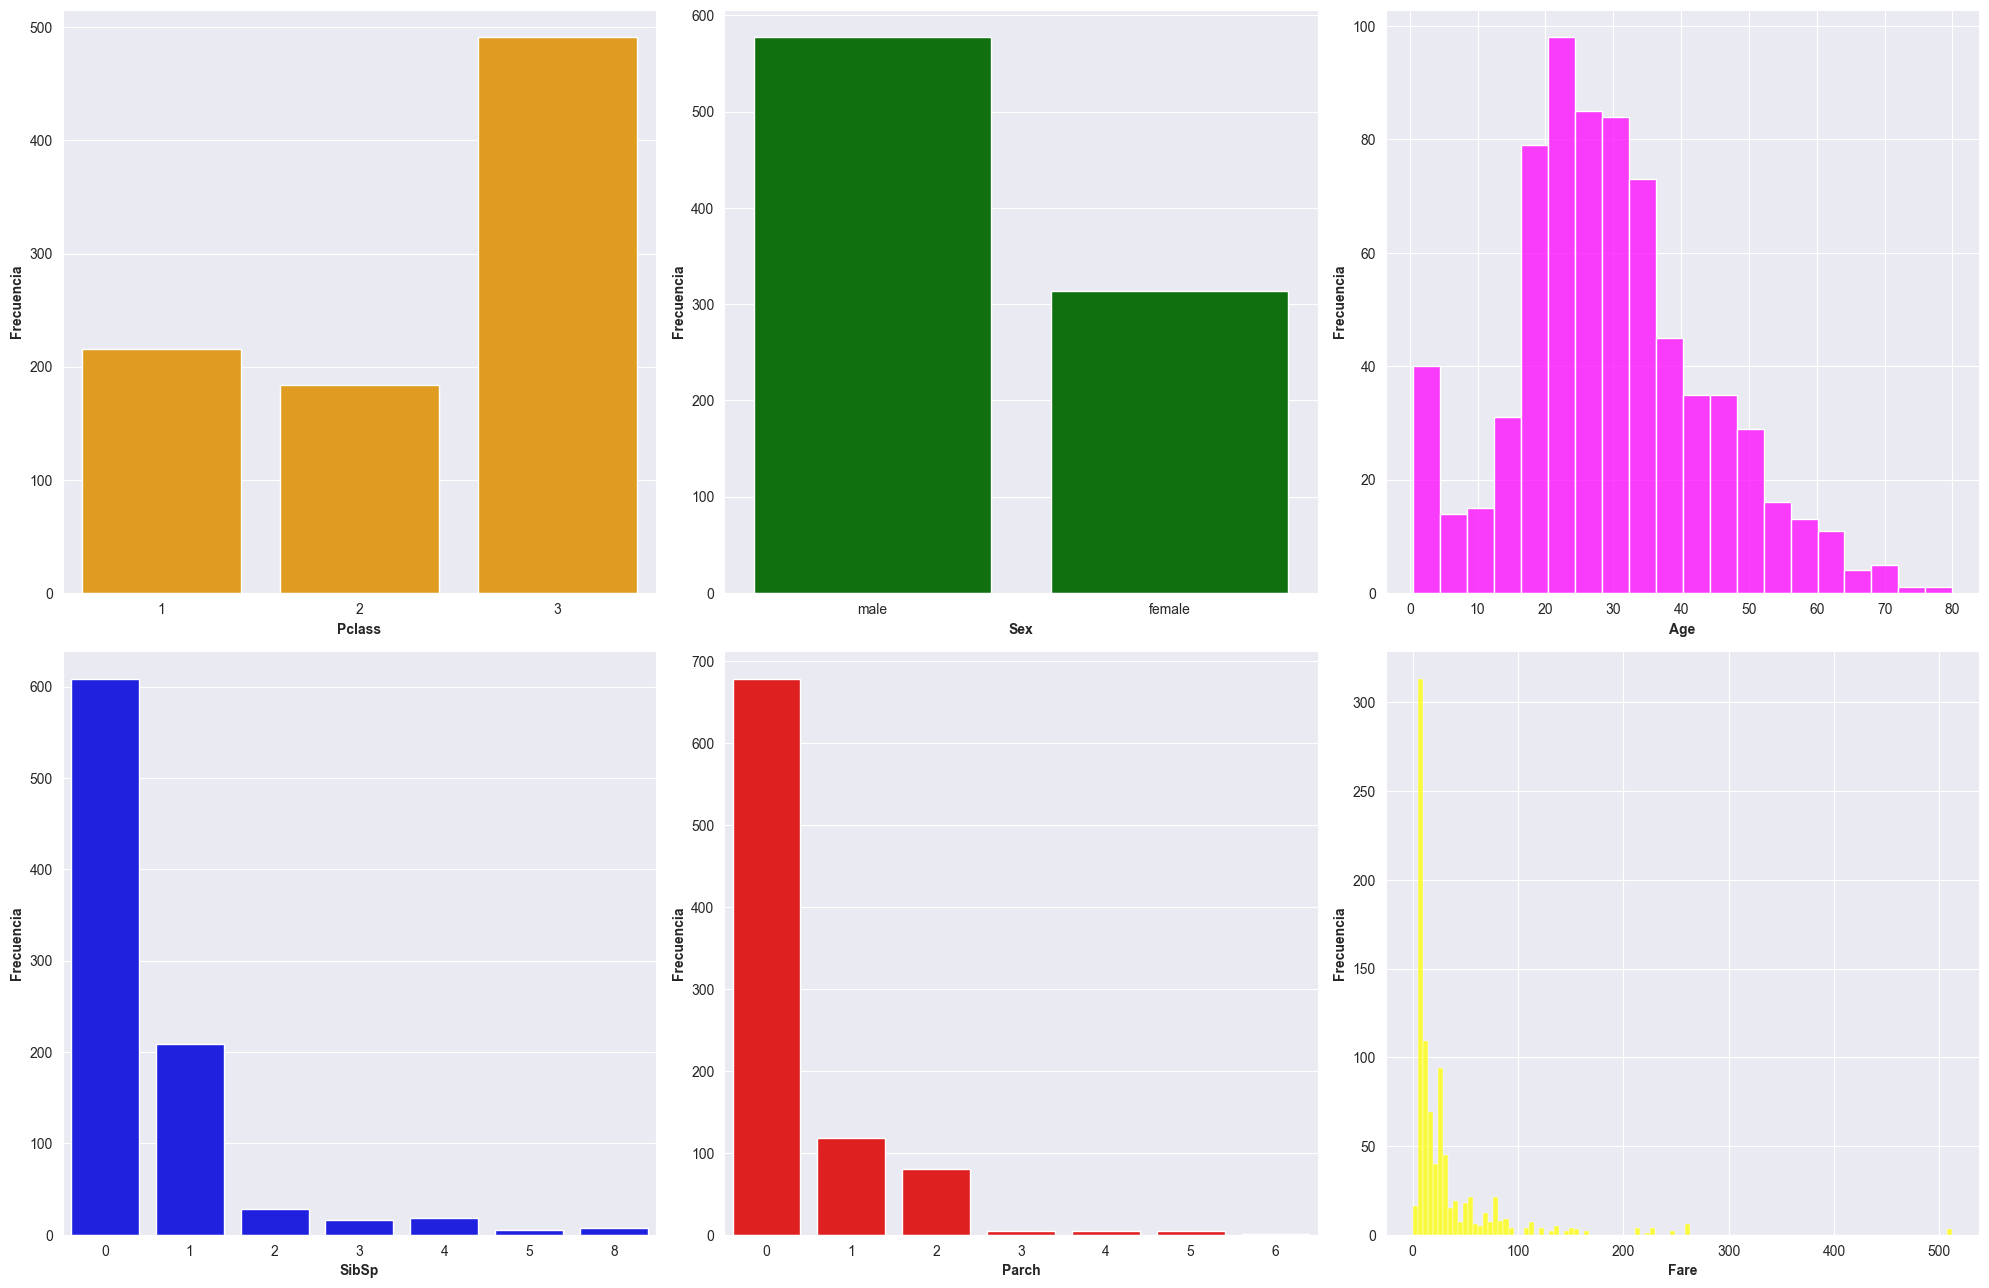

In [577]:
colors = ['orange', 'green', 'magenta', 'blue', 'red', 'yellow']
labels = df.columns.drop('Survived')

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 13))

for i,col in enumerate(labels):
    if col == 'Age' or col == 'Fare':
        plt.subplot(2,3,i+1)
        axi = sns.histplot(x=df[col], color=colors[i], stat='count')
        plt.xlabel(labels[i], weight='bold')
        plt.ylabel('Frecuencia', weight='bold')
    else:
        plt.subplot(2,3,i+1)
        axi = sns.countplot(x=df[col], color=colors[i])
        plt.xlabel(labels[i], weight='bold')
        plt.ylabel('Frecuencia', weight='bold')

plt.tight_layout(pad=1.1)
plt.show()

##### Distribución de las variables respecto al objetivo

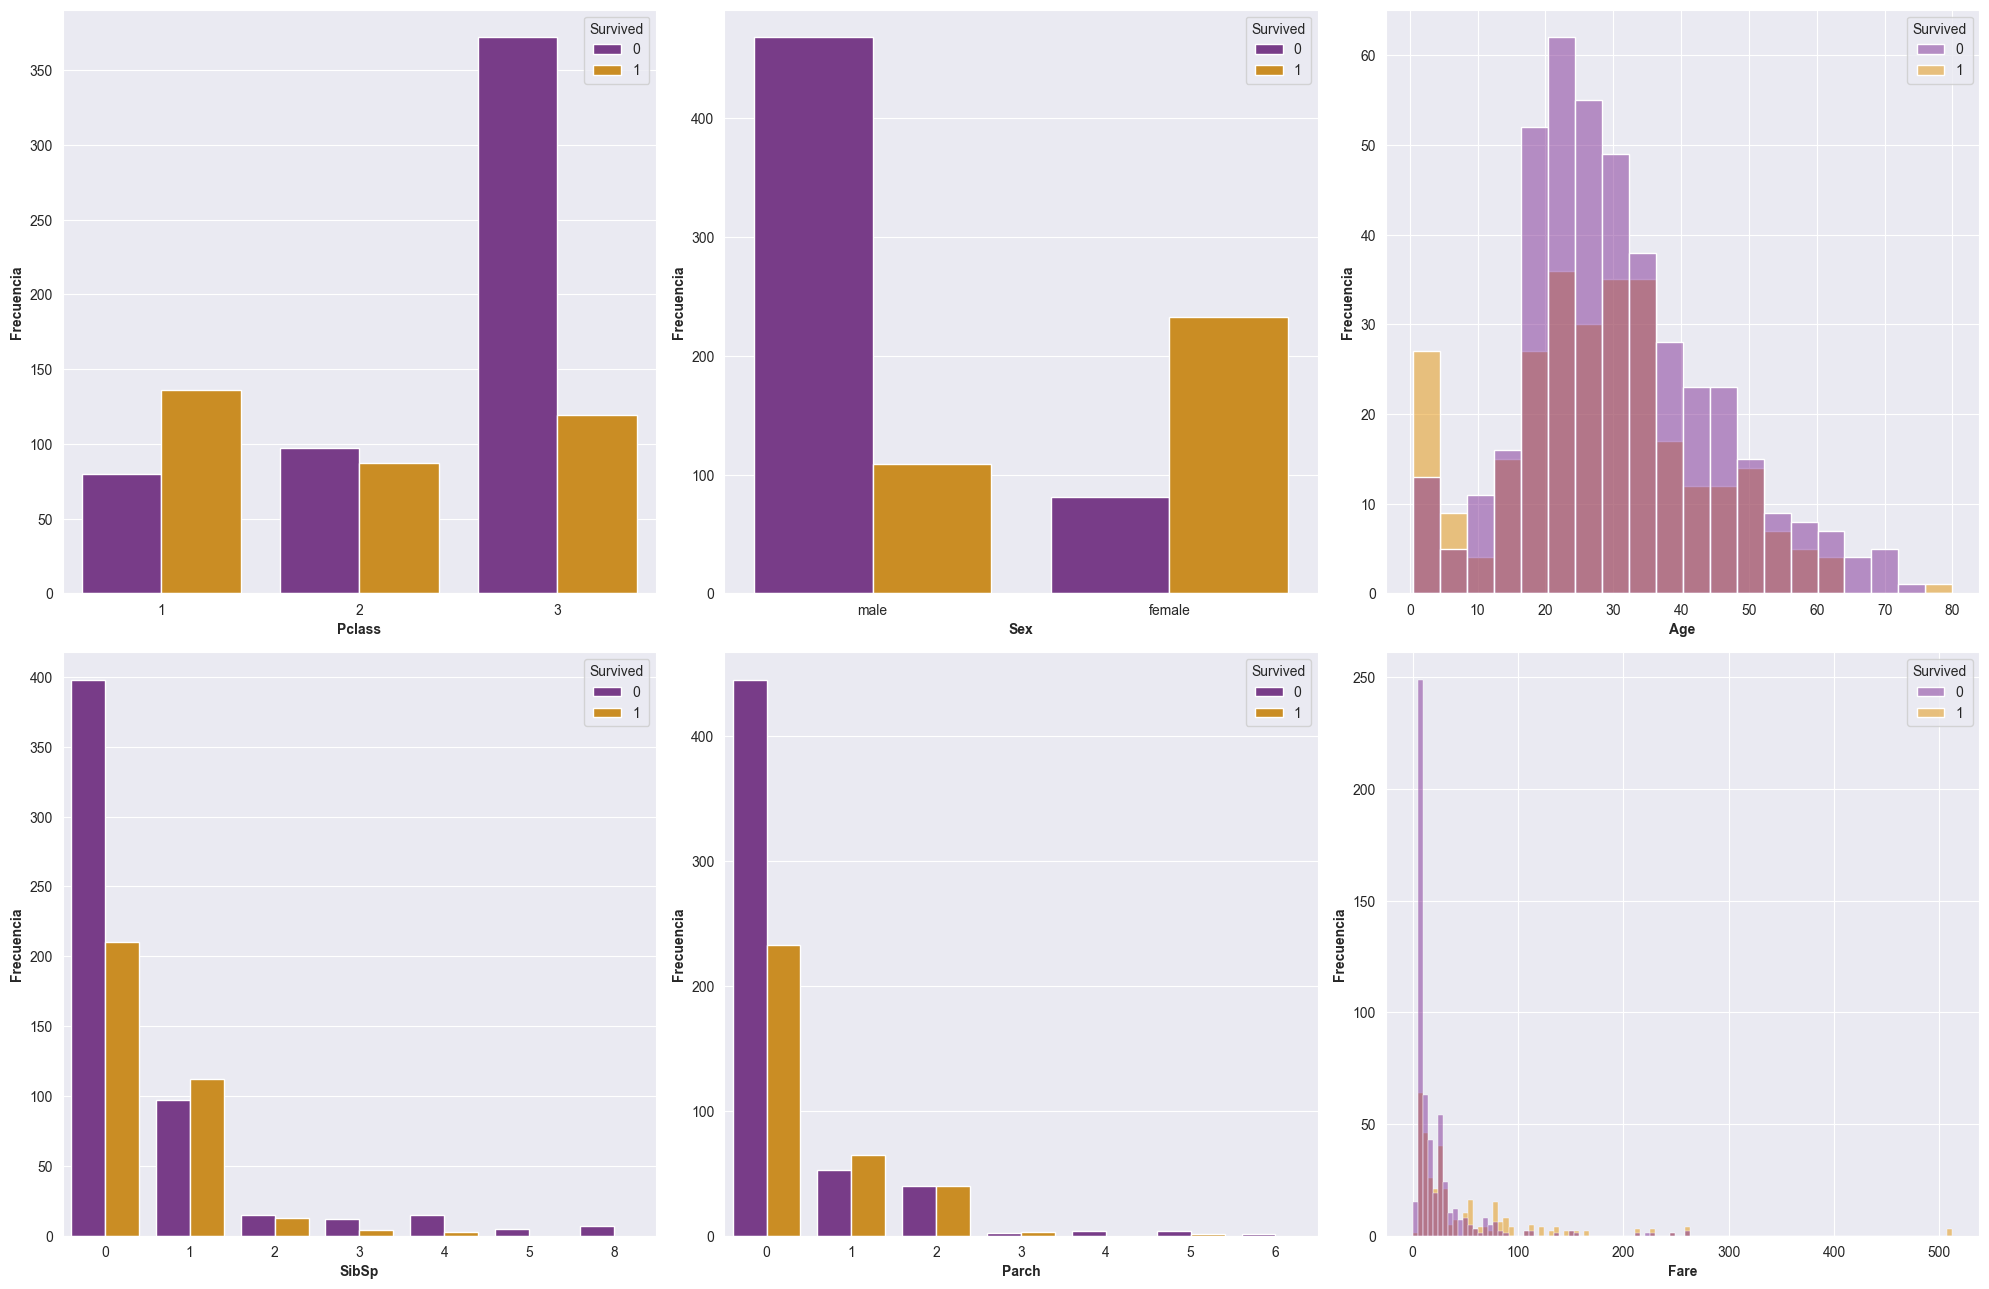

In [578]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 13))

labels = df.columns.drop('Survived')

for i,col in enumerate(labels):
    if col == 'Age' or col == 'Fare':
        plt.subplot(2,3,i+1)
        axi = sns.histplot(data=df, x=col, hue='Survived', palette='CMRmap', stat='count')
        plt.xlabel(labels[i], weight='bold')
        plt.ylabel('Frecuencia', weight='bold')
    else:
        plt.subplot(2,3,i+1)
        axi = sns.countplot(data=df, x=col, hue='Survived', palette='CMRmap')
        plt.xlabel(labels[i], weight='bold')
        plt.ylabel('Frecuencia', weight='bold')

plt.tight_layout(pad=1.1)
plt.show()

##### Analisis de correlación entre variables

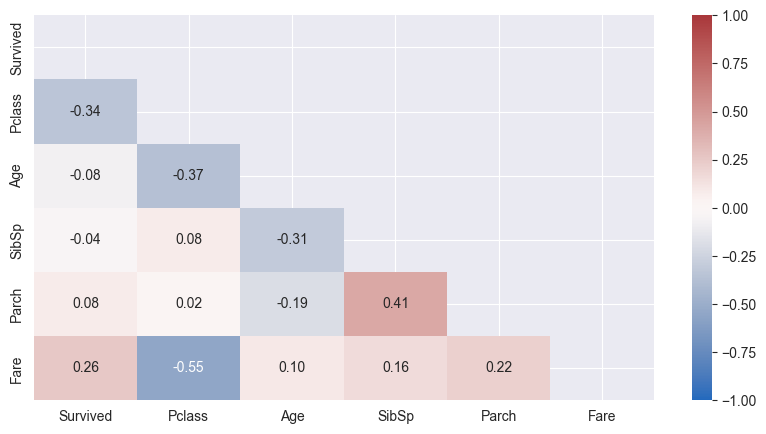

In [579]:
corr = df.select_dtypes(include=['float', 'int']).corr()
plt.subplots(figsize=(10, 5))
ax = sns.heatmap(corr, annot=True, cmap='vlag', cbar=True, fmt='.2f', mask=np.triu(corr), vmax=1, vmin=-1, center=0)
plt.show()

## 2. Procesamiento de los datos

In [580]:
cols = ['Sex', 'Pclass']
df = pd.get_dummies(df, columns=cols, prefix=cols, prefix_sep='_', dtype='int32')

df.head()

,Survived,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,0,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,1,0,0
4,0,35.0,0,0,8.0500,0,1,0,0,1


In [581]:
imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
# df['Age'] = df['Age'].fillna(df['Age'].mean())
# df['Age'] = df['Age'].astype('float64')

# Elección y entrenamiento del modelo

In [582]:
SEED = 42

In [583]:
X = df.drop('Survived', axis=1)
y = df['Survived']

In [584]:
# Listado de los distintos métodos de escalado
scaled_models = {
                'Sin escalar': X,
                'Normalización': MinMaxScaler(),
                'Estadarización': StandardScaler(),
                'Método Robusto': RobustScaler(),
                'Escala Absoluta': MaxAbsScaler(),
                'Transformación Cuantil': QuantileTransformer( n_quantiles=100, random_state=SEED)
                }

In [585]:
# Listado de Modelos ML
models = {
          'K-vecinos': KNeighborsClassifier(),
          'Regresión logística': LogisticRegression(random_state=SEED, max_iter=1000),
          'Árbol de decisión': DecisionTreeClassifier(random_state=SEED),
          'Bosques de decisión': RandomForestClassifier(random_state=SEED),
          'Maquina vectorial': SVC(random_state=SEED),
          'Clasificador perceptron': MLPClassifier(random_state=SEED, max_iter=1000)
          }

In [586]:
# Declaración del diccionario que va albergar la precisión de cada modelo para cada método de transformación
accuracy = {}

for k, trans in scaled_models.items():
    # Transformación de los datos con cada uno de los métodos
    X_new = X
    
    if k != 'Sin escalar':
        X_new = trans.fit_transform(X)
        X_new = pd.DataFrame(X_new, columns=X.columns)

    accuracy[k] = []
    
    for key, model in models.items():
        X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=SEED, stratify=y) # Separación de los datos en entrenamiento y prueba
        
        X_train_sm, y_train_sm = SMOTE(random_state=SEED).fit_resample(X_train, y_train)
        model.fit(X_train_sm, y_train_sm) # Entrenamiento del modelo
        
        y_pred = model.predict(X_test) # Predicción del modelo
        
        acc = round(accuracy_score(y_test, y_pred) * 100, 2) # Precisión del modelo
        accuracy[k].append(acc) # Resultados de precisión de cada uno de los modelos

# Contrucción del DataFrame con los resultados obtenidos
df_results = pd.DataFrame(accuracy, index=models.keys())
df_results.style.highlight_max(color='red', axis=1)

,Sin escalar,Normalización,Estadarización,Método Robusto,Escala Absoluta,Transformación Cuantil
K-vecinos,66.480000,80.450000,80.450000,79.330000,79.890000,78.210000
Regresión logística,80.450000,78.210000,79.330000,79.890000,78.210000,77.650000
Árbol de decisión,79.890000,77.650000,81.010000,78.210000,77.650000,82.120000
Bosques de decisión,82.680000,82.680000,83.800000,83.240000,82.120000,82.680000
Maquina vectorial,64.250000,77.650000,80.450000,80.450000,77.650000,79.890000
Clasificador perceptron,79.330000,83.240000,83.800000,79.890000,82.120000,79.890000


## Modelo machine learning final

In [594]:
# Escalado de los datos
sc = StandardScaler()
X_scaled = pd.DataFrame(sc.fit_transform(X), columns=X.columns)

# Separación entre datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=SEED, stratify=y)

X_train_sm, y_train_sm = SMOTE(random_state=SEED).fit_resample(X_train, y_train)
# Modelo
mlp = MLPClassifier(random_state=SEED, max_iter=1000) # modelado con parámetros ajustados por defecto
mlp.fit(X_train_sm, y_train_sm) # Entrenamiento del modelo

# Predicción
y_pred = mlp.predict(X_test)

# Resultados
print(f'La precisión del modelo de MLPClassifier es del {round(accuracy_score(y_test, y_pred) * 100, 2)}%')
print(f'El informe de clasificación es: \n {classification_report(y_test, y_pred)}')

La precisión del modelo de MLPClassifier es del 83.8%
El informe de clasificación es: 
               precision    recall  f1-score   support

         0.0       0.87      0.86      0.87       110
         1.0       0.79      0.80      0.79        69

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



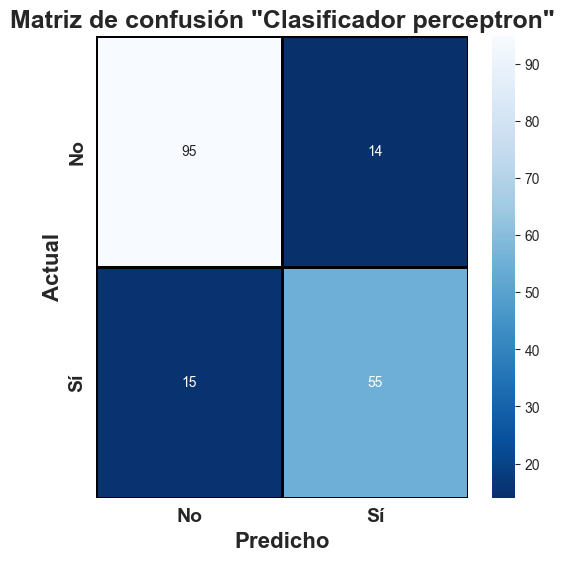

In [588]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))

sns.heatmap(cm.T,
            cmap='Blues_r',
            linecolor='black',
            linewidths=1,
            annot=True,
            fmt='',
            xticklabels=['No', 'Sí'],
            yticklabels=['No', 'Sí']
            )

plt.xlabel('Predicho', weight='bold', fontsize=16)
plt.ylabel('Actual', weight='bold', fontsize=16)
plt.xticks(weight='bold', fontsize=14)
plt.yticks(weight='bold', fontsize=14)
plt.title('Matriz de confusión "Clasificador perceptron"', weight='bold', fontsize=18)
plt.show()

## Busqueda de los mejores hiperparametros

In [589]:
kf = KFold(n_splits=10, shuffle=True, random_state=SEED)
mlp = MLPClassifier(random_state=SEED, max_iter=1000)
gs = RandomizedSearchCV(mlp, param_distributions={'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)],
                                                  'activation': ['tanh', 'relu'],
                                                    'solver': ['sgd', 'adam'],
                                                    'alpha': [0.0001, 0.05],
                                                    'learning_rate': ['constant', 'adaptive'],
                                                    'learning_rate_init': [0.001, 0.01, 0.1],
                                                    'max_iter': [1000, 2000, 3000],
                                                    'early_stopping': [True, False],
                                                    'warm_start': [True, False]
        }, cv=kf, scoring='accuracy', n_jobs=-1, verbose=1, refit=True, random_state=SEED)

In [590]:
gs.fit(X_train_sm, y_train_sm)
gs.best_params_


Fitting 10 folds for each of 10 candidates, totalling 100 fits


{'warm_start': True,
 'solver': 'sgd',
 'max_iter': 3000,
 'learning_rate_init': 0.1,
 'learning_rate': 'adaptive',
 'hidden_layer_sizes': (100,),
 'early_stopping': False,
 'alpha': 0.05,
 'activation': 'relu'}

In [591]:
gs.score(X_test, y_test)

0.8379888268156425

##### Como nos da el mismo resultado con parametros que sin ellas, nos quedamos con el modelo sin parametros

In [592]:
# Reentrenamos el modelo
mlp = MLPClassifier(random_state=SEED, max_iter=1000) # modelado con parámetros ajustados por defecto
mlp.fit(X_train_sm, y_train_sm) # Entrenamiento del modelo
mlp.score(X_test, y_test)

0.8379888268156425

In [593]:
# Guardar el modelo
joblib.dump(mlp, open('models/titanic_model.pkl', 'wb'))

# Guardar el scaler
joblib.dump(sc, open('models/titanic_scaler.pkl', 'wb'))